# Pre-processing data  - Snakeclef2021

About:
- This notebook focus on preprocessing data that will be  use for test and training.
---
David Andrés Torres Betancour <br/>
Computer Engineering  Student <br/>
University of Antioquia <br/>
davida.torres@udea.edu.co

## Importing Libraries

In [1]:
import h5py
import numpy as np
import cv2
import math
import time
import random
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
%matplotlib inline

## Tools

### Kaggle Tools

In [2]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def checkIfFileExist(file_name):
    return os.path.exists(os.path.abspath(file_name))

def credentialsUploaded():
  first_time = True;
  waiting_time = 0
  print()
  while checkIfFileExist('kaggle.json')==False and  waiting_time<180:
      if first_time:
        print(bcolors.BOLD + "Upload kaggle.json file following the above instructions ^^^^^^^^\n " + bcolors.ENDC)   
        print(bcolors.WARNING + "Waiting user upload kaggle.json file in root folder\n" + bcolors.ENDC)  
        first_time = False
      time.sleep(2)
      waiting_time +=2
  if waiting_time>=120:
      raise Exception("kaggle.json file has not been uploaded") 
  print(bcolors.OKGREEN + " kaggle.json file uploaded!" + bcolors.ENDC)   
  os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd() #Setup kaggle.json dir

def relocateData():
    !tar -xf snakeclef2021.zip -v
    !del snakeclef2021.zip 
    !mkdir kaggle_data
    !move data kaggle_data
    !move data.csv kaggle_data 


def unzipData():
    !tar -xf snakeclef2021.zip -v
    !del snakeclef2021.zip 

def fetchDatasetFromKaggle(dataset_name, force_fetch=False):
    
  print(bcolors.BOLD + "Fetching data from kaggle ( This may take some time)..." + bcolors.ENDC)   
  if force_fetch==True:
   ! kaggle datasets download -d deividt/{dataset_name} --force #Download dataset
         
   process_info=! kaggle datasets download -d deividt/{dataset_name} --force #Download dataset
   if "100%" in list(process_info)[-1]:
       print(bcolors.OKGREEN + "Data from kaggle successfully fetch\n" + bcolors.ENDC)
       print(bcolors.BOLD + "Unzipping data... s\n" + bcolors.ENDC)
       unzipData()
       print(bcolors.BOLD + "Relocating data... s\n" + bcolors.ENDC)
       relocateData()
       print(bcolors.OKGREEN + "Data is ready in your local folder!\n" + bcolors.ENDC)
   elif "404 - Not Found" in list(process_info)[0]: 
       print(bcolors.FAIL + "404 - Dataset  Not Found in 'deividt' Account\n" + bcolors.ENDC)
   else:
       assert False,list(process_info)[-1]

  else:
    if checkIfFileExist("kaggle_data"):
       print(bcolors.WARNING + "Data already exists locally\nIf you want force fetch set force_fetch parameter to True" + bcolors.ENDC)
       return
    process_info =  ! kaggle datasets download -d deividt/{dataset_name} 
    if "Skipping" in list(process_info)[0]:
       print(bcolors.WARNING + "Data already exists locally\nIf you want force fetch set force_fetch parameter to True" + bcolors.ENDC)
    elif "100%" in list(process_info)[-1]:
        print(bcolors.OKGREEN + "Data from kaggle successfully fetch\n" + bcolors.ENDC)
        print(bcolors.BOLD + "Unzipping data... s\n" + bcolors.ENDC)
        unzipData()
        print(bcolors.BOLD + "Relocating data... s\n" + bcolors.ENDC)
        relocateData()
        print(bcolors.OKGREEN + "Data is ready in  kaggle_data folder!\n" + bcolors.ENDC)
    elif "404 - Not Found" in list(process_info)[0]: 
        print(bcolors.FAIL + "404 - Dataset  Not Found in 'deividt' Account\n" + bcolors.ENDC)
    else:
        assert False,list(process_info)[-1]

def kaggle_setConfig(dataset_title="testing"):

  fileName=os.path.abspath('pre_proccesed_data/dataset-metadata.json')
  !kaggle datasets init -p  {os.path.abspath('pre_proccesed_data')}
  addTitle2JSON(fileName,dataset_title)

def kaggle_createDataset(public=False):
  if public: 
    !kaggle datasets create -p  {os.path.abspath('pre_proccesed_data')} -u
  else: 
    !kaggle datasets create -p  {os.path.abspath('pre_proccesed_data')}
   
def kaggle_updateDataset(commit_message='Updating files'):
   log_info=!kaggle datasets version -p {os.path.abspath('pre_proccesed_data')} -m commit_message
   print(log_info)
def kaggle_saveData():
  
  res = input("Do you want upload created data in  your kaggle Account? [y/n] ")
  
  if  res.lower()!="y" :
    return print("Upload canceled")

  res = readOption( msg = "Create new dataset[1] or update old one[2]? [1/2]")
  
  dataset_title = input("Enter dataset name: ")
  assert len(res)>0 , "Invalid length "

  kaggle_setConfig(dataset_title)

  if res=="1": #Create new dataset
    res = readOption( msg = "Create dataset Private[1] or Public [2]? [1/2]" )
    public_dataset = True if int(res)==2 else False
    kaggle_createDataset(public_dataset)
  elif res=="2": #Update dataset
    commit_msg = input ("Enter commit message (Ex. 'version 1.4') : ")
    print(bcolors.WARNING + f"Updating dataset in kaggle... \n" + bcolors.ENDC)
    kaggle_updateDataset(commit_msg)


### Preprocessing Tools

In [3]:
def reOrderForGrouping(dataF,group_size):

  dataF.sample(frac = 1)#Shuffle dataframe
  newDf = pd.DataFrame({'image_path' : [],'breed' : [],'breed_encode' : []})
  
  min_breedCount = dataF['breed'].value_counts()[-1]

  breeds = pd.unique(dataF['breed'])
  class_size = group_size //len(breeds)

  totalGroups = min_breedCount//class_size
 
  for i in range(totalGroups):

      for breed in   breeds :
          df_breed = dataF[dataF.breed==breed]
          df_breed = df_breed[class_size*i:class_size*(i+1)]
          newDf = newDf.append( df_breed )
  
  return newDf     

def selectTopBreeds(dataF,num=10):
    selected=dataF['binomial'].value_counts()[:num]
    return selected.index.tolist();




def normalize_and_write_data_into_h5_file(dataF,dest_filepath, n_px):
    

    data_shape = (len(dataF), n_px * n_px * 3)
    dataset_name = "input_data"
    

    with h5py.File(dest_filepath, 'a') as f:
        f.create_dataset(dataset_name, data_shape, np.float32)      
        for i,image_id in enumerate(dataF['image_path']):
            path  = os.path.abspath(f'kaggle_data/{image_id}')
            try:
          
              img=cv2.imread(path)
              img = cv2.resize(img, (n_px, n_px), interpolation=cv2.INTER_CUBIC)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              #Normalize the image - convert the each pixel value between 0 and 1
              img = img / 255
                #Reshape the image - roll it up into a column vector
              img = img.ravel()            
              #img[None] makes it a proper array instead of rank 1 array
              f[dataset_name][i, ...] = img[None]
            except:
              continue
    return;


def fixImagePath(dataF):
    imgs_paths=dataF.image_path.tolist()
    for i,img_path in enumerate(imgs_paths):
        imgs_paths[i]='data/'+img_path.split('/')[-1]   
    return imgs_paths
def savePreproccessedCSV(dataF):
  !mkdir pre_proccesed_data
  dataF.to_csv(os.path.abspath('pre_proccesed_data/pre_proccessed_data.csv'))
  print(bcolors.OKGREEN + "pre_proccessed_data.csv saved!\n" + bcolors.ENDC)


### File Tools 

In [22]:
def write_labels_into_h5_file(dest_filepath, labels):
    
    dataset_name = "input_labels"
    
    with h5py.File(dest_filepath, 'a') as f:
        f.create_dataset(dataset_name, (len(labels),), np.int8)
        f[dataset_name][...] = labels

def convert_images_to_data_in_h5_file(dataF, dest_h5_file_path, n_px, batch_size = 1024):
    


    #Create Labels based upon the substring contained in the filename
    labels = (dataF['breed_encode']).to_numpy()
    
    #Number of images
    m = len(dataF) 
    n_complete_batches = math.ceil(m / batch_size)
    
    pbar = tqdm(range(n_complete_batches))
    for i in pbar:
    
        dest_file_path = dest_h5_file_path + str(i + 1) + ".h5"   
        
        if checkIfFileExist(dest_file_path):
            print(bcolors.WARNING + f"Group {i+1} already exist in pre_proccessed_data  folder\n" + bcolors.ENDC)
            continue;
        pbar.set_description("Creating .h5 file for group %s" % i)           
        start_pos = i * batch_size
        end_pos = min(start_pos + batch_size, m)
        df_filepaths_batch = dataF.iloc[start_pos: end_pos]
        labels_batch = labels[start_pos: end_pos]
        normalize_and_write_data_into_h5_file(df_filepaths_batch,dest_file_path, n_px)
        write_labels_into_h5_file(dest_file_path, labels_batch)

    print(bcolors.OKGREEN + "Images successfully saved in .h5 files !\n" + bcolors.ENDC)

def addTitle2JSON(fileName,dataset_title):
    data = readFile(fileName)
    data = addTitle2Data(data,dataset_title)
    writeFile(fileName,data)
    
def writeFile(fileName,data):
  with open(fileName,'w') as json_file:
      # Guardar la informacion
      json.dump(data,json_file)
      print("File "+fileName+" updated")

def readFile(fileName):
  with open(fileName, "r") as json_file: 
     return json.load(json_file)

def addTitle2Data(data,title):
  data['id'] = data['id'].split('/')[0]+'/'+title
  data['title'] = title
  return data
def readOption(msg):

  res = input(msg)
  assert res=='1' or res=='2',"Invalid option"
  return res

### Extra Tools

In [25]:
def showRandomImage(x,y): 
  index = random.randint(0,x.shape[0])
  
  image = x[index]
  plt.imshow(image)
  print("Img shape:",image.shape)
  print('breed:', y[index])

def getRandomGroup(max_groups=1):

  group_num =str(random.randint(1,max_groups))
  destination_filepath =os.path.abspath('pre_proccesed_data/group_'+group_num+'.h5')
  with h5py.File(destination_filepath, "r") as f:
      
      
      print(bcolors.WARNING + f"Reading data from group {group_num} !\n" + bcolors.ENDC)

      x = f["input_data"][:]
      x = x.reshape(x.shape[0],224,224,3)

      y = f["input_labels"][:]

      print("Keys: ",list(f.keys()))
      print('x shape =', x.shape, '| y shape =', y.shape)
      
      
      
      return x,y,group_num

## Preprocessing data



### 0)   Fetch and read data :



1. Upload Kaggle credentials file ( kaggle.json  ) 

 - In order to use the Kaggle’s public API, you must first authenticate using an API token. For that follow the next steps: <br/> <br/>
     1. Go to https://www.kaggle.com/
     2. Click on your user profile picture
     3. Then on "Account" from the dropdown menu. This will take you yo your account settings
     4. Scroll down to the section of the page labelled API
     5. To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine named "kaggle.json"
     6.  <font color='red'>YOU MUST UPLOAD kaggle.json FILE in the ROOT FOLDER/)</font> 



In [6]:
credentialsUploaded()


 kaggle.json file uploaded!


2. Downloading original dataset [snakeclef2021](https://www.kaggle.com/deividt/snakeclef2021) from Kaggle. 
<br/>
<font color='red'>Fetching data and unzipping files can take several minutes ( at least 30 min)  </font> 
<br/>


In [7]:
fetchDatasetFromKaggle( dataset_name = "snakeclef2021")

Fetching data from kaggle ( This may take some time)...
Data already exists locally
If you want force fetch set force_fetch parameter to True


3. Read .csv :

In [8]:

df = pd.read_csv('kaggle_data/data.csv')
df.head(5)

,binomial,country,continent,genus,family,UUID,source,subset,class_id,image_path
0,Pantherophis spiloides,United States of America,North America,Pantherophis,Colubridae,fbc816e9552643a2bce4f655b2f3c4e1,inaturalist,train,523,/Datasets/SnakeCLEF-2021/inaturalist/fbc816e95...
1,Masticophis taeniatus,United States of America,North America,Masticophis,Colubridae,cbc7ad7141a642f2b92ef7fe05c9d608,inaturalist,train,430,/Datasets/SnakeCLEF-2021/inaturalist/cbc7ad714...
2,Crotalus pyrrhus,United States of America,North America,Crotalus,Viperidae,fc4db72953ae4c978ac50acb33adce0c,inaturalist,train,183,/Datasets/SnakeCLEF-2021/inaturalist/fc4db7295...
3,Haldea striatula,United States of America,North America,Haldea,Colubridae,2068c79c956d43dc8a45106e0c808aed,inaturalist,train,305,/Datasets/SnakeCLEF-2021/inaturalist/2068c79c9...
4,Natrix natrix,Russia,Europe,Natrix,Colubridae,3e376aaf4f8d42e991c0c8ddc5972f95,inaturalist,train,471,/Datasets/SnakeCLEF-2021/inaturalist/3e376aaf4...


### 1) Select top 10 breeds with most images

0. Check top 10 images

In [9]:
df['binomial'].value_counts()[:10]

Thamnophis sirtalis            22163
Storeria dekayi                17535
Pantherophis obsoletus         13012
Crotalus atrox                 12344
Nerodia sipedon                12211
Pituophis catenifer            11487
Pantherophis alleghaniensis     8846
Agkistrodon contortrix          8085
Diadophis punctatus             7689
Nerodia erythrogaster           7435
Name: binomial, dtype: int64

1. Select top 10 images:

In [10]:
selected_breed = selectTopBreeds(df,10)

2. Filter dataframe with selected breeds

In [11]:

df = df[df.binomial.isin(selected_breed)] 

print(pd.unique(df.binomial))

print("Total breeds:",len ( pd.unique(df.binomial)))

['Thamnophis sirtalis' 'Pituophis catenifer' 'Storeria dekayi'
 'Nerodia erythrogaster' 'Diadophis punctatus' 'Crotalus atrox'
 'Pantherophis alleghaniensis' 'Nerodia sipedon' 'Agkistrodon contortrix'
 'Pantherophis obsoletus']
Total breeds: 10


### 1) Drop and rename columns:

In [12]:
# 1. Dropping columns
df = df.drop(columns=['source','class_id','UUID','country','genus','family','continent','subset'])

# 2. Renaming columns
df.columns=['breed','image_path']

# 3. Show results
df.head(5)


,breed,image_path
14,Thamnophis sirtalis,/Datasets/SnakeCLEF-2021/inaturalist/2925c6778...
17,Pituophis catenifer,/Datasets/SnakeCLEF-2021/inaturalist/1b849238b...
21,Storeria dekayi,/Datasets/SnakeCLEF-2021/inaturalist/dab7fe49d...
22,Nerodia erythrogaster,/Datasets/SnakeCLEF-2021/inaturalist/7c4bd815b...
24,Diadophis punctatus,/Datasets/SnakeCLEF-2021/inaturalist/7060dc6cb...


4. Fix image_path

In [13]:
df.image_path = fixImagePath(df)
df

,breed,image_path
14,Thamnophis sirtalis,data/2925c677825448a7935fad227c1fa9b2.jpg
17,Pituophis catenifer,data/1b849238b16941b282c2d608a8c4c687.jpg
21,Storeria dekayi,data/dab7fe49d8204bce887305fd5fa887c0.jpg
22,Nerodia erythrogaster,data/7c4bd815bf0b4454b6db043fccd54fd1.jpg
24,Diadophis punctatus,data/7060dc6cb41e4fcc8415a9007ac3bca6.jpg
...,...,...
385993,Pituophis catenifer,data/2d39a392ecee4be1849d8d6c5e231c1f.jpg
386001,Storeria dekayi,data/f0a50a4676a34a2f99c3cb2451c6acd5.jpg
386002,Thamnophis sirtalis,data/4513bbe7752d49dabdff2dd6484c82fc.jpg
386003,Thamnophis sirtalis,data/fca4ce9644b84454bf2d2967bbfd6597.jpg


### 3) Encoding breeds

In [14]:
df['breed_encode'] = LE.fit_transform(df['breed'])
df.head(5)

,breed,image_path,breed_encode
14,Thamnophis sirtalis,data/2925c677825448a7935fad227c1fa9b2.jpg,9
17,Pituophis catenifer,data/1b849238b16941b282c2d608a8c4c687.jpg,7
21,Storeria dekayi,data/dab7fe49d8204bce887305fd5fa887c0.jpg,8
22,Nerodia erythrogaster,data/7c4bd815bf0b4454b6db043fccd54fd1.jpg,3
24,Diadophis punctatus,data/7060dc6cb41e4fcc8415a9007ac3bca6.jpg,2


### 4) Preparing dataframe for grouping:

In [15]:
df = reOrderForGrouping( df,group_size=2000)
df['breed'].value_counts()

Thamnophis sirtalis            7400
Diadophis punctatus            7400
Pantherophis alleghaniensis    7400
Pituophis catenifer            7400
Agkistrodon contortrix         7400
Nerodia erythrogaster          7400
Pantherophis obsoletus         7400
Nerodia sipedon                7400
Storeria dekayi                7400
Crotalus atrox                 7400
Name: breed, dtype: int64

5) Save preproccessed .csv

In [16]:
savePreproccessedCSV(df)

A subdirectory or file pre_proccesed_data already exists.


pre_proccessed_data.csv saved!



### 5)  Create groups and convert them to .h5 file

In [24]:

convert_images_to_data_in_h5_file(df, dest_h5_file_path=os.path.abspath('pre_proccesed_data')+'/group_', n_px = 224, batch_size= 2000)

100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 3365.63it/s]

Group 1 already exist in pre_proccessed_data  folder

Group 2 already exist in pre_proccessed_data  folder

Group 3 already exist in pre_proccessed_data  folder

Group 4 already exist in pre_proccessed_data  folder

Group 5 already exist in pre_proccessed_data  folder

Group 6 already exist in pre_proccessed_data  folder

Group 7 already exist in pre_proccessed_data  folder

Group 8 already exist in pre_proccessed_data  folder

Group 9 already exist in pre_proccessed_data  folder

Group 10 already exist in pre_proccessed_data  folder

Group 11 already exist in pre_proccessed_data  folder

Group 12 already exist in pre_proccessed_data  folder

Group 13 already exist in pre_proccessed_data  folder

Group 14 already exist in pre_proccessed_data  folder

Group 15 already exist in pre_proccessed_data  folder

Group 16 already exist in pre_proccessed_data  folder

Group 17 already exist in pre_proccessed_data  folder

Group 18 already exist in pre_proccessed_data  folder

Group 19 already ex

### 6) File verification





1. Select random group:






In [26]:
x,y,groupNum =getRandomGroup( max_groups=10 )

Reading data from group 3 !

Keys:  ['input_data', 'input_labels']
x shape = (2000, 224, 224, 3) | y shape = (2000,)


2. Select random image from selected group:

Img shape: (224, 224, 3)
breed: 9


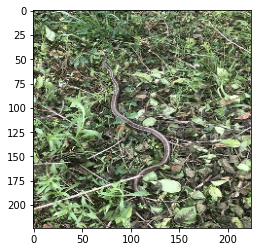

In [31]:
showRandomImage(x,y)

### 7) Saving created files in Kaggle 


In [ ]:
kaggle_saveData()

Do you want upload created data in  your kaggle Account? [y/n]  y
Create new dataset[1] or update old one[2]? [1/2] 2
Enter dataset name:  snake-breeds


Data package template written to: C:\Users\datcx\Documents\github\Snakes-Classifier\pre_proccesed_data\dataset-metadata.json
File C:\Users\datcx\Documents\github\Snakes-Classifier\pre_proccesed_data\dataset-metadata.json updated


Enter commit message (Ex. 'version 1.4') :  version 1.8


Updating dataset in kaggle... 



In [3]:
from  tqdm import tqdm 
import os
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd() #Setup kaggle.json dir

def reShowDir():
   
    ! kaggle datasets download -d deividt/snake-breeds 
def showDir():
    if True:
     reShowDir()


  0%|          | 0.00/1.72M [00:00<?, ?B/s]
 58%|#####8    | 1.00M/1.72M [00:00<00:00, 2.83MB/s]
100%|##########| 1.72M/1.72M [00:00<00:00, 4.15MB/s]
